Using TensorFlow backend.


 9338880/11490434 [=======================>......] - ETA: 0s(50000, 28, 28) (50000,)


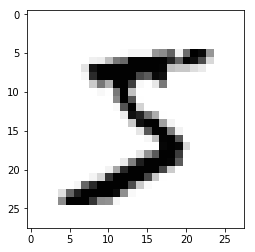

In [1]:
from preprocessed_mnist import load_dataset
import numpy as np
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
import tensorflow as tf
import numpy as np
s = tf.InteractiveSession()

In [3]:
def flatten(array):
    return array.reshape((array.shape[0],28*28))

X_train = flatten(X_train)
X_val = flatten(X_val)
X_test = flatten(X_test)

In [4]:
#weights between input and first hidden layer with 128 neurons 

def make_weights(l_1,l_2,l_3):
    global b_1,b_2,b_3,weights_1,weights_2,weights_3
    weights_1 = tf.Variable(initial_value= tf.random_normal((X_train.shape[1],l_1),\
                                                            mean=0,stddev=0.2),name='weights_1',dtype='float32')
    #weights between  first hidden layer with 128 neurons  and second with 64 neurons

    weights_2 = tf.Variable(initial_value= tf.random_normal((l_1,l_2),mean=0,stddev=0.2),\
                            name='weights_2',dtype='float32')

    #weights between  second hidden layer with 64 neurons  and softmax output with 10 neurons

    weights_3 = tf.Variable(initial_value= tf.random_normal((l_2,l_3),mean=0,stddev=0.2),\
                            name='weights_3',dtype='float32')



    b_1 = tf.Variable(tf.random_normal((l_1,),mean=0,stddev=0.1),name='bias_1',dtype='float32')
    b_2 = tf.Variable(tf.random_normal((l_2,),mean=0,stddev=0.1),name='bias_2',dtype='float32')
    b_3 = tf.Variable(tf.random_normal((l_3,),mean=0,stddev=0.1),name='bias_3',dtype='float32')
make_weights(128,128,10)

In [5]:
input_X = tf.placeholder('float32', shape=(None, X_train.shape[1]))
input_y = tf.placeholder('int32', shape=(None,))


In [6]:
predicted_y = tf.nn.sigmoid(tf.matmul(input_X,weights_1) + b_1)
predicted_y = tf.nn.sigmoid(tf.matmul(predicted_y,weights_2) + b_2)
predicted_y = tf.matmul(predicted_y,weights_3) + b_3 #bug in tf.nn.softmax

loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=input_y, logits=predicted_y))
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [7]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

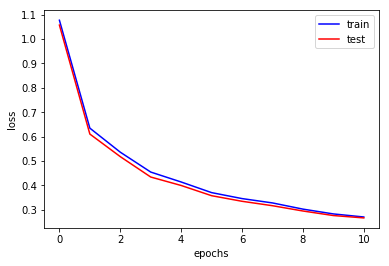

loss at epoch 10:0.2699
accuracy test score at epoch 10:0.9277


In [ ]:

%%time
from IPython import display

from sklearn.metrics import accuracy_score
s.run(tf.global_variables_initializer())
break_all = False
losses = []
losses_t = []
iters = []
for i in range(70):
    if break_all:
        break
    X_train, y_train = unison_shuffled_copies(X_train, y_train)
    for batch in range(0,X_train.shape[0],1000):
        if np.random.random() > 0.7:
            shift = np.random.randint(-5,5)
            X_to_train = np.roll(X_train[0+batch:batch+1000],shift,1) #naive augmentation
        else:
            X_to_train = X_train[0+batch:batch+1000]
        s.run(optimizer, {input_X: X_to_train, input_y: y_train[0+batch:batch+1000]})
        if batch % 10000 == 0:
            acc_sc = accuracy_score(y_test, s.run(tf.arg_max(predicted_y,1), {input_X:X_test}))
            if acc_sc >= 0.98:
                break_all = True
                break
    
    if i % 1 == 0:
        loss_i = s.run(loss, {input_X: X_train, input_y: y_train})
        loss_t = s.run(loss, {input_X: X_test, input_y: y_test})
        iters.append(i)
        losses.append(loss_i)
        losses_t.append(loss_t)
        plt.plot(iters,losses,color ='blue',label = 'train')
        plt.plot(iters,losses_t,color ='red',label = 'test')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.legend()
        display.clear_output(wait=True)
        plt.show()
        print("loss at epoch %i:%.4f" % (i, loss_i))
        print("accuracy test score at epoch %i:%.4f" % (i, acc_sc))

In [ ]:
print("train Acc:", accuracy_score(y_train, s.run(tf.arg_max(predicted_y,1), {input_X:X_train}) ))
print("test Acc:", accuracy_score(y_test, s.run(tf.arg_max(predicted_y,1), {input_X:X_test})))